In [1]:
! pwd

/home/comp2


In [2]:
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
from pycocotools.coco import COCO
import os
from PIL import Image

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
class CustomCocoDataset(torch.utils.data.Dataset):
    def __init__(self, root, annFile, transform=None):
        self.root = root
        self.coco = COCO(annFile)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transform = transform

    def __getitem__(self, index):
        img_id = self.ids[index]
        coco = self.coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        path = coco.loadImgs(img_id)[0]['file_name']

        # Изображение
        img = Image.open(os.path.join(self.root, path)).convert("RGB")

        # Аннотации
        boxes = []
        labels = []
        masks = []
        for ann in anns:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x+w, y+h])
            labels.append(ann['category_id'])
            masks.append(coco.annToMask(ann))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['masks'] = masks

        if self.transform is not None:
            img, target = self.transform(img, target)

        return img, target

    def __len__(self):
        return len(self.ids)


In [5]:
data_dir = "/home/comp2/Загрузки/vineyards.v1i.coco-segmentation"
train_dataset = CustomCocoDataset(root=os.path.join(data_dir, "train"), annFile=os.path.join(data_dir, "train", "_annotations.coco.json"))
val_dataset = CustomCocoDataset(root=os.path.join(data_dir, "valid"), annFile=os.path.join(data_dir, "valid", "_annotations.coco.json"))

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [6]:
def collate_fn(batch):
    # Разделяем изображения и метки
    images, targets = zip(*batch)

    # Преобразуем изображения в тензоры
    images = [F.to_tensor(img) for img in images]

    # Объединяем в батч и перемещаем на устройство
    images = torch.stack(images, dim=0).to(device)

    # Обрабатываем метки
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    return images, targets

In [7]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

In [8]:
# Создание модели
model = maskrcnn_resnet50_fpn(pretrained=True)
num_classes = len(train_dataset.coco.getCatIds()) + 1  # включая фон
model.roi_heads.box_predictor.cls_score = torch.nn.Linear(1024, num_classes)
model.roi_heads.mask_predictor.mask_fcn_logits = torch.nn.Conv2d(256, num_classes, kernel_size=(1, 1))
model.to(device)
model.train()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [9]:
# Оптимизатор и функция потерь
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [12]:
# Обучение
num_epochs = 10

for epoch in range(num_epochs):
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()



    print(f"Epoch {epoch}/{num_epochs}, Loss: {losses.item()}")

# Сохранение модели
torch.save(model.state_dict(), "maskrcnn_model.pth")


Epoch 0/10, Loss: 1.0163869857788086
Epoch 1/10, Loss: 1.0224566459655762
Epoch 2/10, Loss: 0.8834130764007568
Epoch 3/10, Loss: 1.0368856191635132
Epoch 4/10, Loss: 0.7043029069900513
Epoch 5/10, Loss: 0.9516173005104065
Epoch 6/10, Loss: 0.6813279390335083
Epoch 7/10, Loss: 0.8705601096153259
Epoch 8/10, Loss: 0.7021334171295166
Epoch 9/10, Loss: 0.7237115502357483


In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_predictions(image, boxes, labels, scores, threshold=0.5):
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(F.to_pil_image(image.cpu()))

    for box, label, score in zip(boxes, labels, scores):
        if score > threshold:
            x_min, y_min, x_max, y_max = box
            width = x_max - x_min
            height = y_max- y_min
            rect = patches.Rectangle((x_min, y_min), width, height, linewidth = 2, edgecolor = 'red', facecolor = 'none')
            ax.add_patch(rect)

    plt.axis('off')
    plt.show()
            

Image 1:


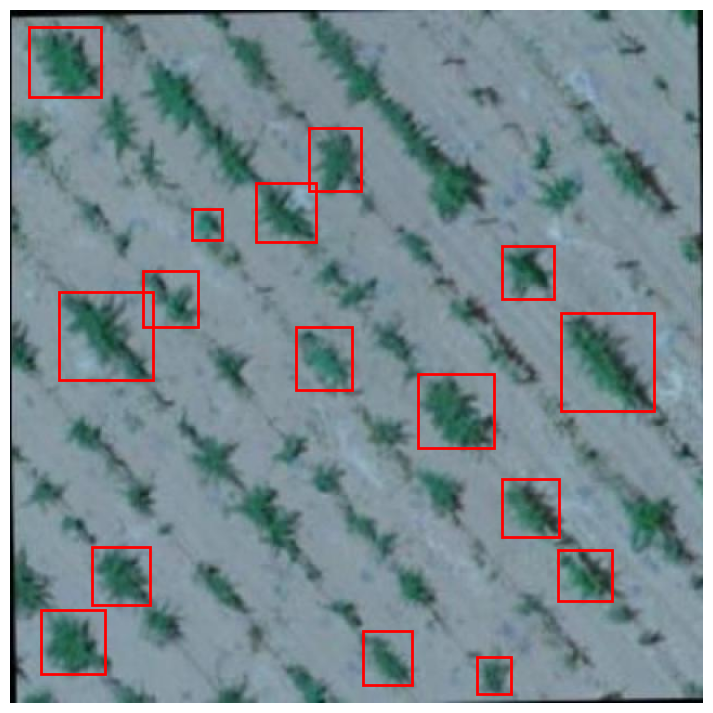

 Label: 1, Score: 0.9984534978866577
 Box: [376.0688  335.61707 446.6209  404.17245]
 Label: 1, Score: 0.9967408776283264
 Box: [ 28.5596  553.18896  87.17789 612.6712 ]
 Label: 1, Score: 0.9963468909263611
 Box: [507.98907 279.3161  594.68304 369.53436]
 Label: 1, Score: 0.9958205223083496
 Box: [ 75.42331 495.65884 128.8687  549.0603 ]
 Label: 1, Score: 0.9955543875694275
 Box: [325.72717 572.60297 370.68958 622.8851 ]
 Label: 1, Score: 0.9952239394187927
 Box: [16.845366 14.850196 83.38189  80.16042 ]
 Label: 1, Score: 0.9936138987541199
 Box: [226.38701 159.13892 282.08853 213.6765 ]
 Label: 1, Score: 0.9924808740615845
 Box: [453.52594 432.45264 506.33432 485.77765]
 Label: 1, Score: 0.990250289440155
 Box: [453.4331  217.52306 502.32822 266.21744]
 Label: 1, Score: 0.9895790219306946
 Box: [122.71387 240.95226 172.84712 292.04077]
 Label: 1, Score: 0.9861454963684082
 Box: [ 44.75627 259.6376  131.5603  341.40518]
 Label: 1, Score: 0.9820238947868347
 Box: [430.86105 597.18774 46

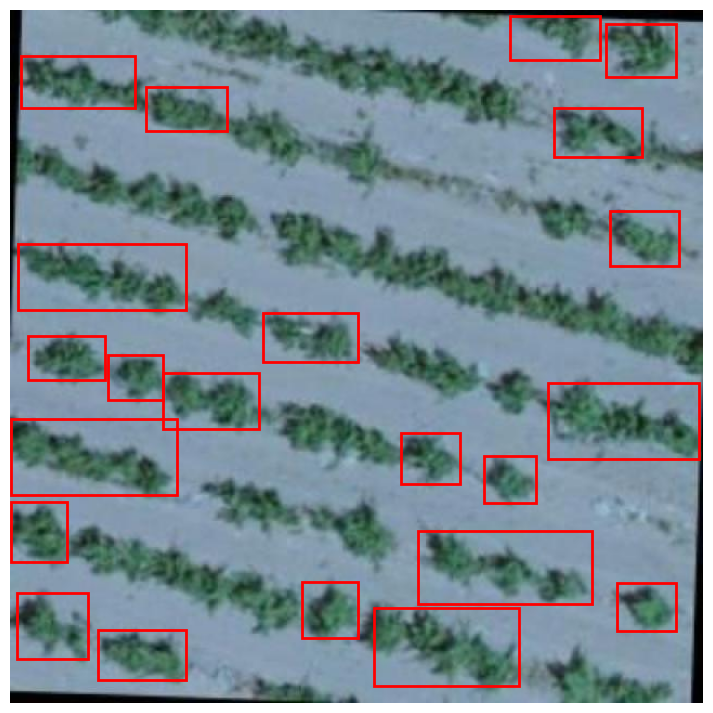

 Label: 1, Score: 0.9987928867340088
 Box: [ 90.43835 318.3256  140.97902 359.44537]
 Label: 1, Score: 0.9978235960006714
 Box: [ 80.55322 571.6851  161.85794 617.9615 ]
 Label: 1, Score: 0.9977193474769592
 Box: [  0.      377.57404 153.43211 447.58847]
 Label: 1, Score: 0.9964936375617981
 Box: [268.9278  527.43085 321.25522 579.8964 ]
 Label: 1, Score: 0.9961695075035095
 Box: [ 16.496016 300.37988   87.41328  341.5825  ]
 Label: 1, Score: 0.9961127638816833
 Box: [ 10.067347  41.808765 114.95469   89.69429 ]
 Label: 1, Score: 0.9954535961151123
 Box: [502.2779   90.12573 582.845   134.98274]
 Label: 1, Score: 0.9953017234802246
 Box: [125.24572   70.327934 200.17499  111.04512 ]
 Label: 1, Score: 0.9952433705329895
 Box: [233.26736 279.7669  321.14084 324.3015 ]
 Label: 1, Score: 0.9949198365211487
 Box: [  5.773773 538.25854   71.78063  598.79095 ]
 Label: 1, Score: 0.9944597482681274
 Box: [376.41464 480.33234 536.6381  547.9839 ]
 Label: 1, Score: 0.9942687749862671
 Box: [335.4

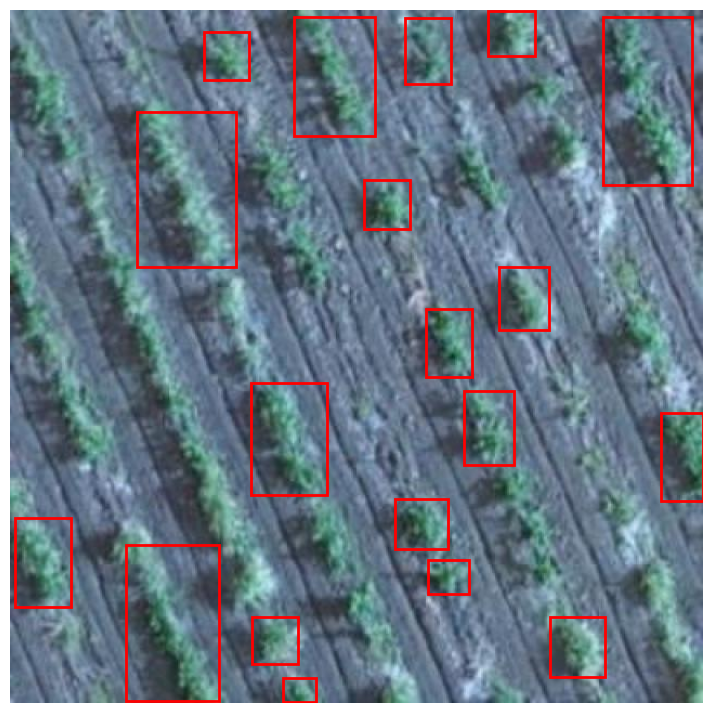

 Label: 1, Score: 0.9996007084846497
 Box: [600.7509  372.0451  639.72327 452.6892 ]
 Label: 1, Score: 0.99957674741745
 Box: [178.52412   19.817856 220.35745   64.05707 ]
 Label: 1, Score: 0.9983322024345398
 Box: [4.4082883e+02 3.8619995e-02 4.8395508e+02 4.2147396e+01]
 Label: 1, Score: 0.9972549080848694
 Box: [261.7983      6.0002503 336.6815    116.17671  ]
 Label: 1, Score: 0.9970332384109497
 Box: [106.245926 493.84308  192.06148  637.2949  ]
 Label: 1, Score: 0.9968528151512146
 Box: [221.97998 343.9498  291.88614 447.56094]
 Label: 1, Score: 0.9962384700775146
 Box: [251.18199 616.5945  281.78708 638.8295 ]
 Label: 1, Score: 0.9953455328941345
 Box: [418.90054 351.01584 465.3448  419.5253 ]
 Label: 1, Score: 0.990119218826294
 Box: [383.37228 275.1854  426.62076 338.47882]
 Label: 1, Score: 0.9896610975265503
 Box: [364.55023     6.4464264 406.60687    68.262344 ]
 Label: 1, Score: 0.9895110726356506
 Box: [498.21198 560.3582  548.96136 615.3629 ]
 Label: 1, Score: 0.98897701

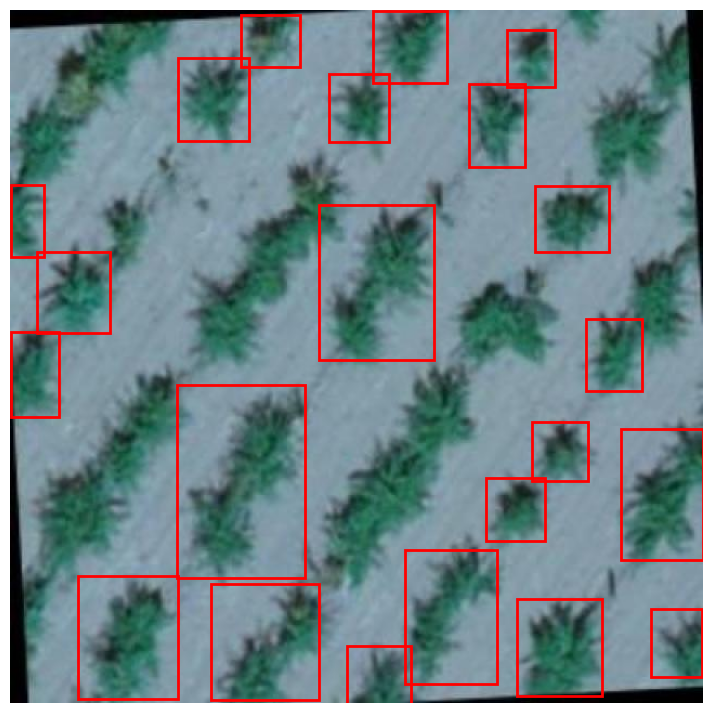

 Label: 1, Score: 0.9990654587745667
 Box: [184.69531 529.8806  284.77182 636.3992 ]
 Label: 1, Score: 0.9986068606376648
 Box: [563.7379  386.11075 639.48895 507.23215]
 Label: 1, Score: 0.9985532164573669
 Box: [591.7968 552.4802 638.9827 615.5785]
 Label: 1, Score: 0.9979386925697327
 Box: [467.3217  543.58026 546.20355 633.12134]
 Label: 1, Score: 0.9979351758956909
 Box: [310.94016 586.77295 369.501   640.     ]
 Label: 1, Score: 0.9978634715080261
 Box: [285.2473  179.58548 390.75986 323.04715]
 Label: 1, Score: 0.9978148937225342
 Box: [334.85007      0.51312256 402.94702     66.564354  ]
 Label: 1, Score: 0.9973249435424805
 Box: [213.24344    3.662813 267.01517   52.099087]
 Label: 1, Score: 0.9971103072166443
 Box: [293.78336   58.170998 349.0637   120.955925]
 Label: 1, Score: 0.9971087574958801
 Box: [439.2776  431.71857 493.90768 489.49902]
 Label: 1, Score: 0.9969095587730408
 Box: [364.13443 498.38824 449.181   622.0811 ]
 Label: 1, Score: 0.9967013001441956
 Box: [458.8

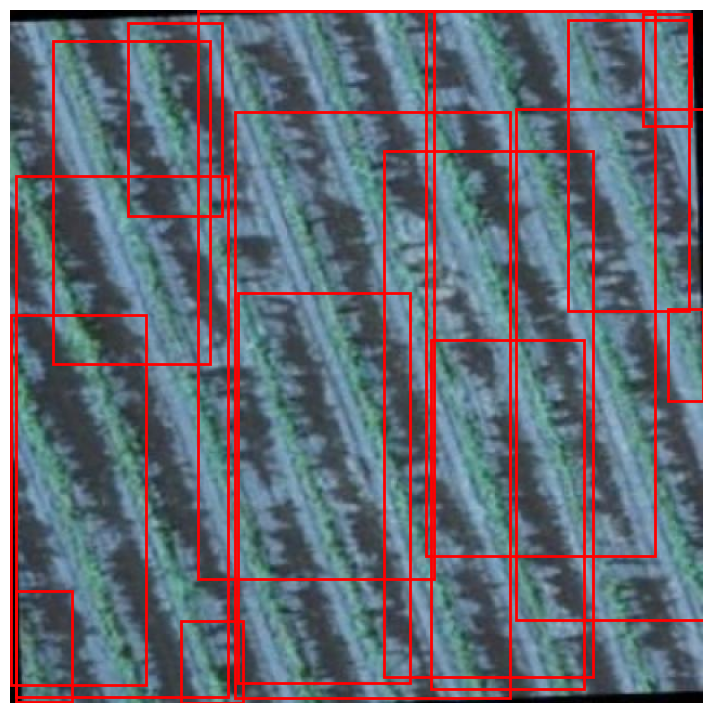

 Label: 1, Score: 0.9990068078041077
 Box: [  4.8757205 152.96297   200.93556   633.9897   ]
 Label: 1, Score: 0.9989759922027588
 Box: [210.40074 260.8503  368.55966 621.4512 ]
 Label: 1, Score: 0.9981744289398193
 Box: [173.53581   0.      390.7331  525.0317 ]
 Label: 1, Score: 0.9981087446212769
 Box: [ 39.143063  27.832472 184.47948  326.12378 ]
 Label: 1, Score: 0.9977344274520874
 Box: [344.57758 129.9879  537.94714 615.1238 ]
 Label: 1, Score: 0.9974623918533325
 Box: [383.93604   0.      595.3364  503.49942]
 Label: 1, Score: 0.9962127208709717
 Box: [157.84521 563.40326 214.31958 639.08234]
 Label: 1, Score: 0.9956697225570679
 Box: [514.73596    9.004028 626.2192   277.47116 ]
 Label: 1, Score: 0.9953163862228394
 Box: [607.0041  275.54553 639.52875 360.86984]
 Label: 1, Score: 0.9945630431175232
 Box: [467.24728  91.38374 640.      562.4583 ]
 Label: 1, Score: 0.9942440390586853
 Box: [  0.       281.56982  125.055786 623.2586  ]
 Label: 1, Score: 0.9896131157875061
 Box: [3

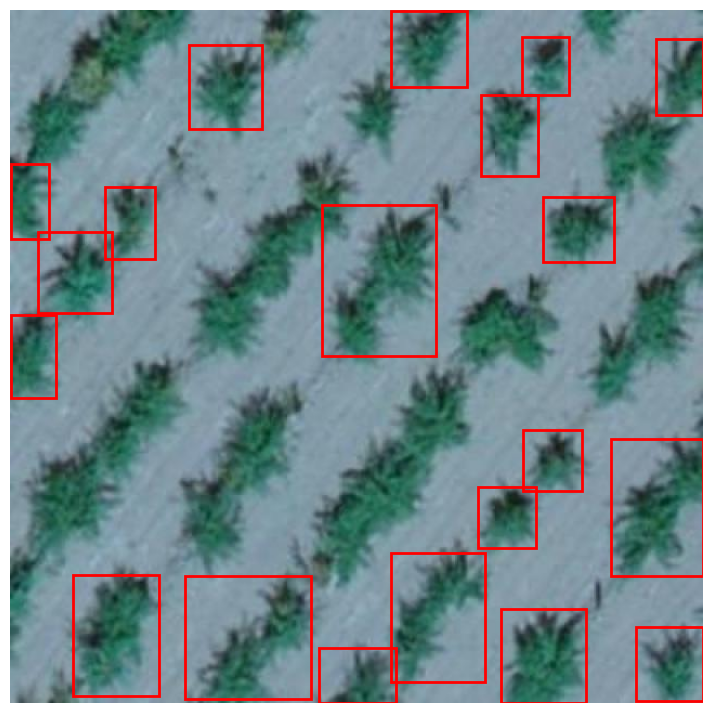

 Label: 1, Score: 0.999415397644043
 Box: [595.6512    26.076181 639.9545    96.16077 ]
 Label: 1, Score: 0.9984098672866821
 Box: [577.49133 569.1286  639.68536 637.8011 ]
 Label: 1, Score: 0.9984080195426941
 Box: [161.48784 522.59467 277.9222  635.71344]
 Label: 1, Score: 0.9982407093048096
 Box: [285.32895 589.12836 356.0251  639.77167]
 Label: 1, Score: 0.9980022311210632
 Box: [491.88205 172.53421 557.4868  232.6387 ]
 Label: 1, Score: 0.9979825019836426
 Box: [6.4366154e-02 1.4189098e+02 3.5896912e+01 2.1110181e+02]
 Label: 1, Score: 0.9974076151847839
 Box: [351.01007 500.6486  438.53345 620.05316]
 Label: 1, Score: 0.9966476559638977
 Box: [ 87.07098 162.89131 133.5942  229.63081]
 Label: 1, Score: 0.9962542057037354
 Box: [473.03793 387.78763 528.0146  443.93213]
 Label: 1, Score: 0.995937705039978
 Box: [472.08347   24.035873 515.6215    78.33174 ]
 Label: 1, Score: 0.9956082701683044
 Box: [554.5358 395.4136 639.5319 522.0881]
 Label: 1, Score: 0.9951653480529785
 Box: [ 57

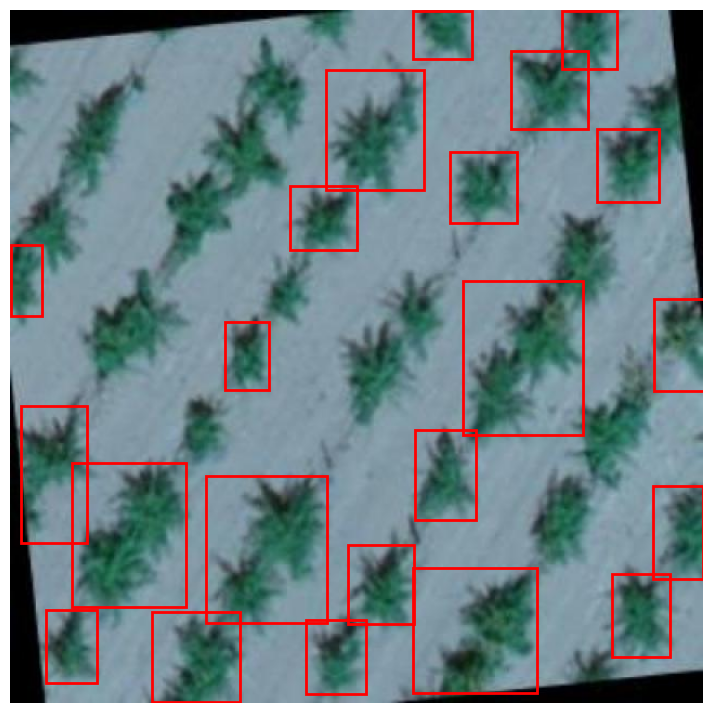

 Label: 1, Score: 0.9985867738723755
 Box: [ 57.07798 417.7214  162.44006 551.0002 ]
 Label: 1, Score: 0.9985602498054504
 Box: [371.4854  514.4848  486.57935 630.27826]
 Label: 1, Score: 0.9982927441596985
 Box: [258.23398 161.65457 320.42105 220.71497]
 Label: 1, Score: 0.9967921376228333
 Box: [593.8282  266.29825 640.      351.00412]
 Label: 1, Score: 0.9963380098342896
 Box: [406.22406 130.69225 467.38052 195.96559]
 Label: 1, Score: 0.9962066411972046
 Box: [541.7084  109.28139 599.1526  176.9174 ]
 Label: 1, Score: 0.9954356551170349
 Box: [198.02478 287.6493  238.3886  350.19412]
 Label: 1, Score: 0.995302677154541
 Box: [371.57285   0.      426.4358   44.75027]
 Label: 1, Score: 0.9950500130653381
 Box: [272.8217 563.089  328.2317 631.6204]
 Label: 1, Score: 0.994562566280365
 Box: [418.30704 249.8201  528.6305  391.87534]
 Label: 1, Score: 0.9936009049415588
 Box: [555.1895 520.4819 608.5655 597.3084]
 Label: 1, Score: 0.992938220500946
 Box: [311.61865 493.18283 372.20914 56

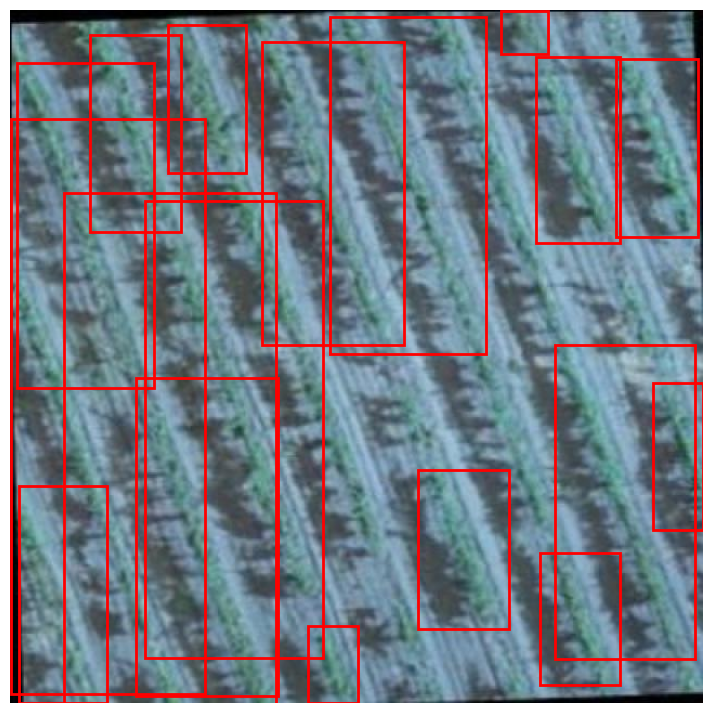

In [ ]:
# Инференс
model.eval()
with torch.no_grad():
    for images, _ in val_loader:
        images = list(image.to(device) for image in images)
        outputs = model(images)
        for i , output in enumerate(outputs):
            print(f"Image {i+1}:")
            boxes = output['boxes'].cpu().numpy()
            labels = output['labels'].cpu().numpy()
            scores = output['scores'].cpu().numpy()
            visualize_predictions(images[i], boxes, labels, scores, threshold=0.5)
            for box, label, score in zip(boxes, labels, scores):
                if score > 0.5:
                    print(f" Label: {label}, Score: {score}")
                    print(f" Box: {box}")